# Time series analysis of CAD-USA exchange rate

In this time series we make an analysis of the Canada-US dollars stock exchange from the years 2000 to 2016. We do some visualizations in plotly and then apply the ARIMA and SARIMA models for seanality. Included in this notebook are the followindgs

The data is obtained from quandl.
The following will be covered


   - Getting the data from quandl: 
   - Visualizing time series data
   - Resampling of data
   - Seasonality test
     - Original time series 
     - Rolling mean 
     - Standard deviations
     - ACF and partial ACF
   - Forecasting
      - Arima


Below are the packages used

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import quandl as qdl
from datetime import datetime

#Set font scale and style
sns.set(font_scale = 2)
sns.set_style('ticks')
plt.style.use('ggplot')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

Changing the size of the default parameter sizes

In [2]:
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#plt.style.use('fivethirtyeight')


__1.  Getting the data__
The data is gotten from quandl. A token is needed to get the data.

In [3]:
data = qdl.get("CUR/CAD", authtoken="---") #add tocken from quandl

In [4]:
data.head(3)

,RATE
DATE,
2000-01-01,1.450456
2000-01-02,1.450456
2000-01-03,1.445373


In [5]:
data.tail(3)

,RATE
DATE,
2016-12-29,1.351305
2016-12-30,1.345070
2016-12-31,1.344466


In [6]:
datar = data.rename(columns = {"Rate": "CAD"})
datar.head()

,RATE
DATE,
2000-01-01,1.450456
2000-01-02,1.450456
2000-01-03,1.445373
2000-01-04,1.450996
2000-01-05,1.450960


Lets extract the dimensions and columns names

In [7]:
data.index = pd.to_datetime(data.index)

Next, we check the data types

In [8]:
# run some files containing custom functions
%run -i 'scripts/helper.py'

__2. Visualization__

__Plot__ the CAD/USD exchange rate data

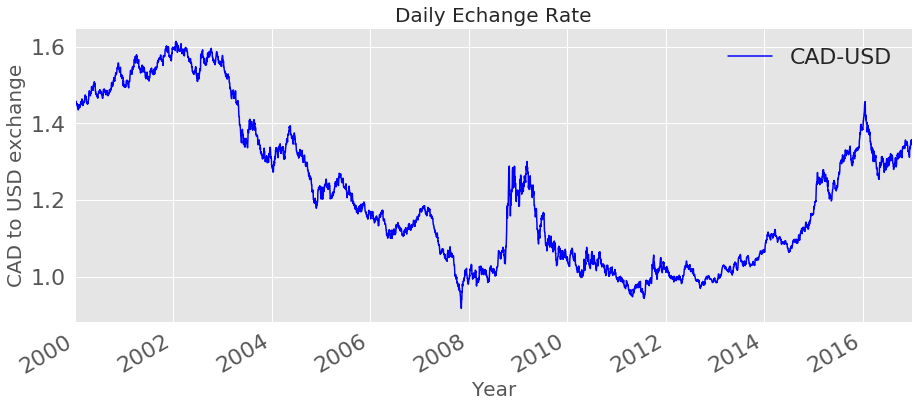

In [9]:
plotTimeseries(data, 'blue', title='Daily Echange Rate')

__3. Resampling__:

Perform a weekly average of the conversion rate.

In [10]:
weekly_data = data.resample('W').mean()

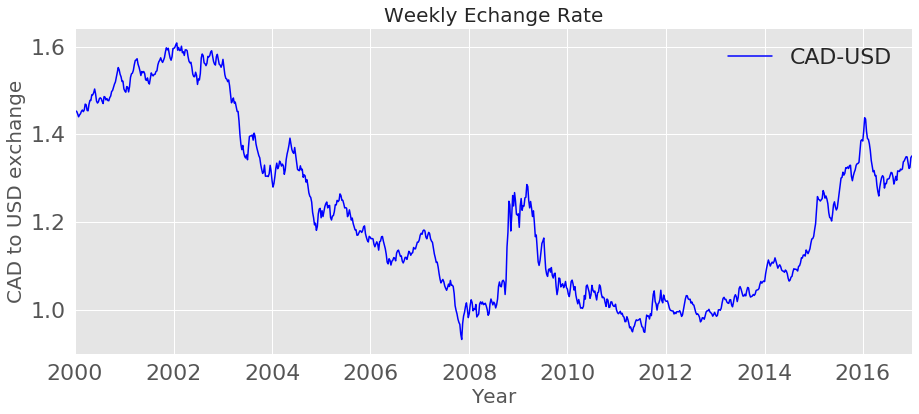

In [11]:
plotTimeseries(weekly_data, 'blue', title='Weekly Echange Rate')

__4. Stationarity__
Below, we make a plot of

 - Original time series 
 - Rolling mean 
 - Standard deviations
 - ACF and partial ACF
 
In addition, the Dickey-Fuller test is also performed

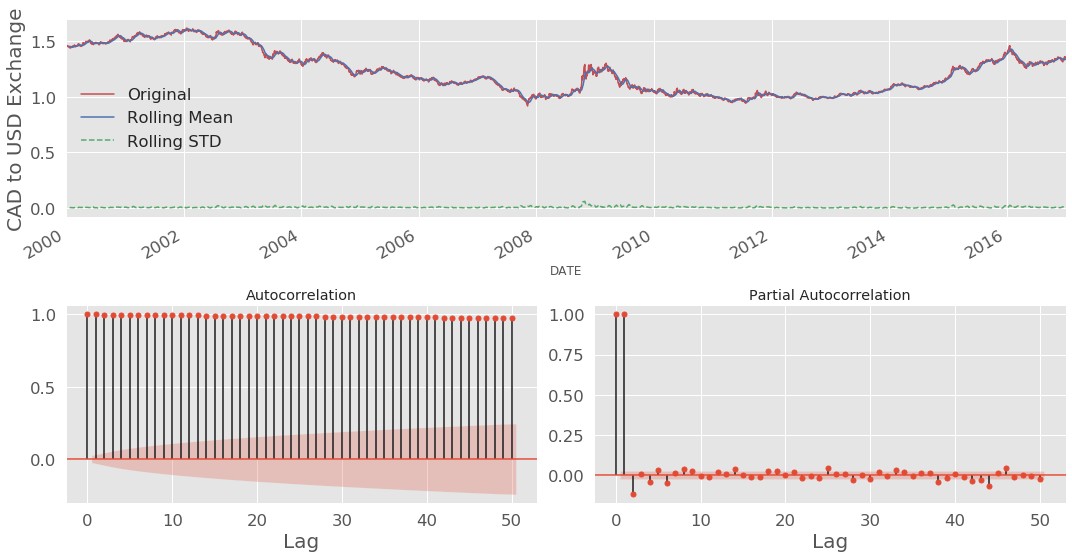

Test statistic: -1.32
p-value: 0.62
Critial Values (1%): -3.43
Critial Values (5%): -2.86
Critial Values (10%): -2.57


In [12]:
plotStationarityTests(data, nlags=50)

__4a. Log Transformation and DFT__

In this section, we perform a logarithm transformation of the data. A check for stationarity of the log transformed time series is also performed

In [13]:
weekly_data['Value_log'] = np.log(weekly_data['RATE']) # take log of the time series

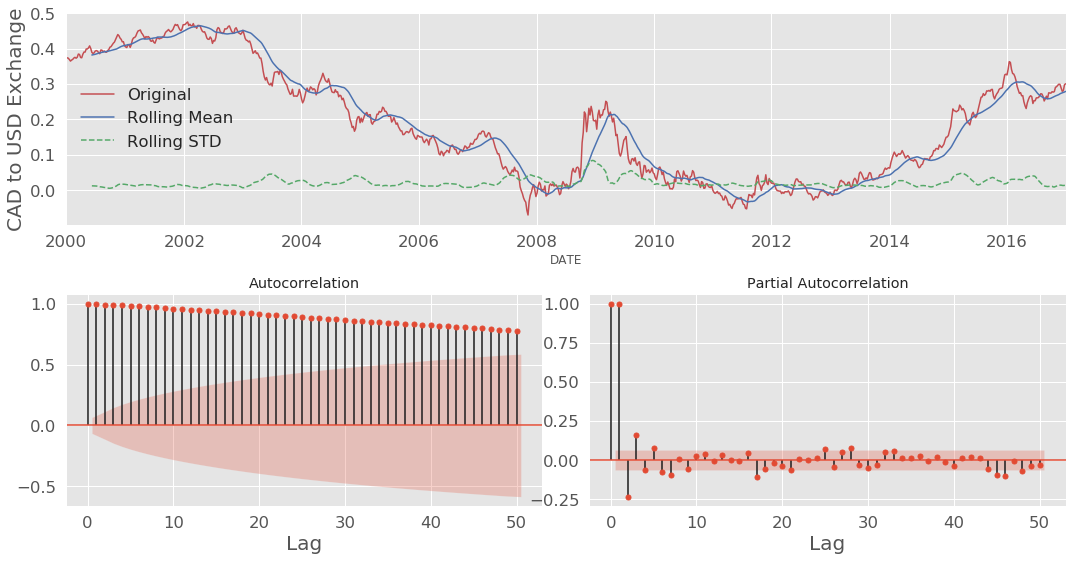

Test statistic: -1.49
p-value: 0.54
Critial Values (1%): -3.44
Critial Values (5%): -2.86
Critial Values (10%): -2.57


In [14]:
plotStationarityTests(weekly_data['Value_log'], nlags=50)

__5. Seasonal decomposition__

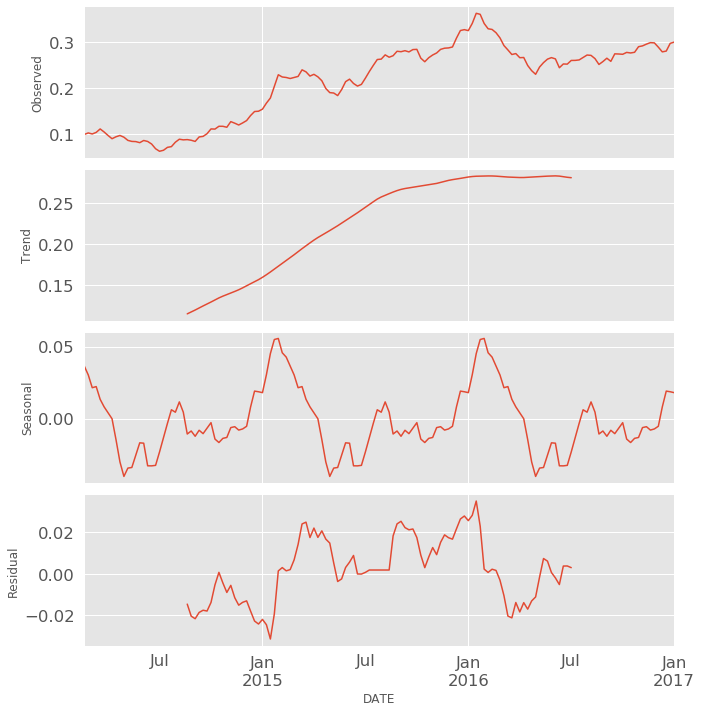

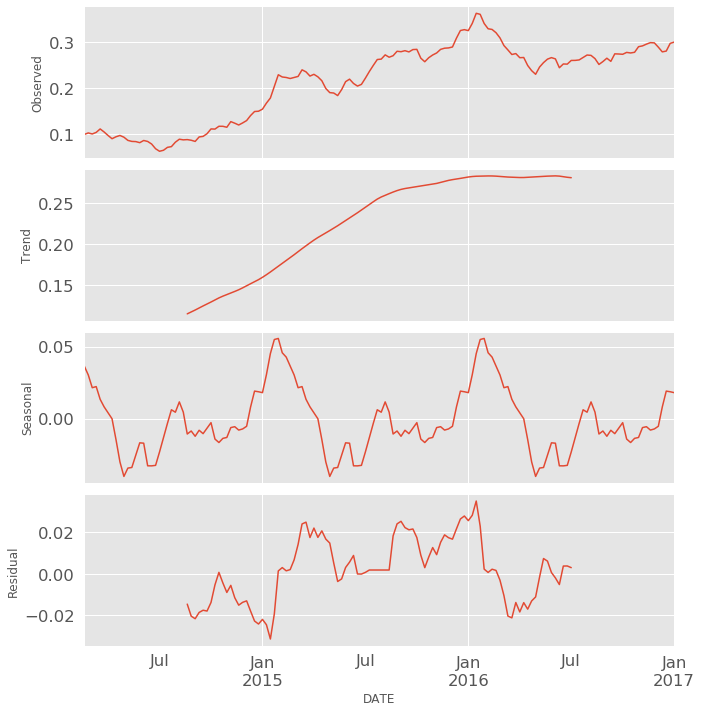

In [15]:
decomposition = seasonal_decompose(weekly_data.Value_log[-150:], model='additive')
#fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
params = {'figure.figsize': (10, 10)}
pylab.rcParams.update(params)
#plt.style.use('fivethirtyeight')
decomposition.plot()

__4c) Differencing of Log Transformed Data__

Now, lets take a look at the first difference of the log transformed data, which signifies the growth rate of the exchange rate from CAD to USD.

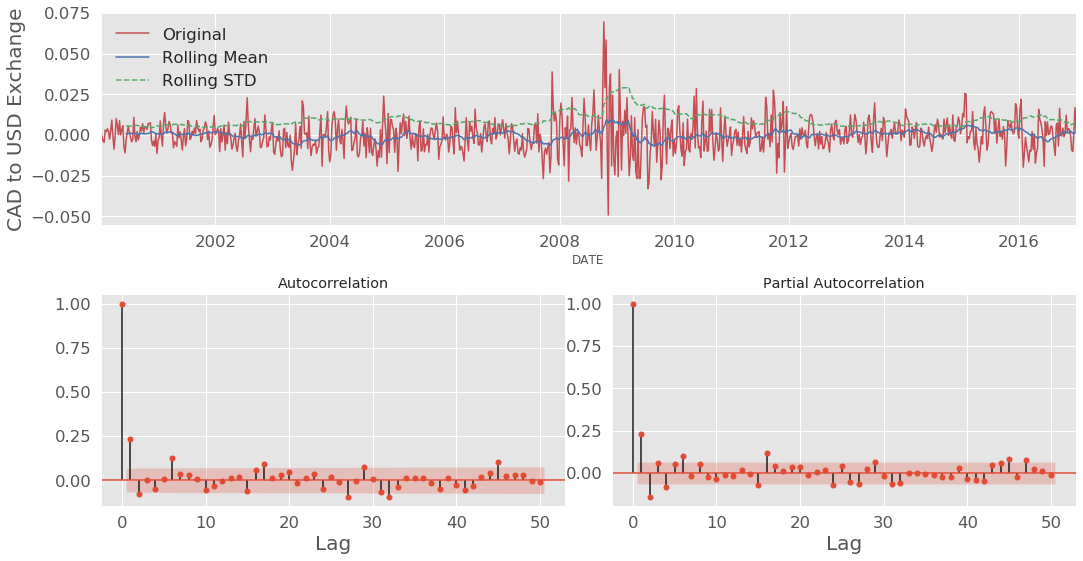

Test statistic: -6.81
p-value: 0.00
Critial Values (1%): -3.44
Critial Values (5%): -2.86
Critial Values (10%): -2.57


In [16]:
weekly_data['Value_log_diff'] = weekly_data['Value_log'] - weekly_data['Value_log'].shift(1)

plotStationarityTests(weekly_data.Value_log_diff.dropna(), nlags = 50)

### Model Training

There statistic test above shows a signicantly less than \\(1\%\\) critical value and the _p-value_ is less than 0.05. Therefore, the time series is stationary with $99\%$ confidence. The ACF and Partial ACF of the differenced log transformed time series evidently decay quickly which corroborate the fact that the differenced log transformed time series is stationary.

__Parameter sstimation__

We will build the Autoregressive Integrated Moving Average (ARIMA) model, which comprises three parameters usually identified as (p,d,q). ARIMA models are a class of models that _explains_ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. 
From the ACF and Partial ACF plots of the stationary series, we can now extract these parameters using the following criteria.

   - AR(p): The Partial ACF is finite and cut off after p lags
   - MA(q): The ACF is finite and cut off after q lags
   - d is the number of differencing needed to achieve stationarity.

In the present problem, we can clearly see that p = q = d = 1


In [17]:
train_start, train_end = '2000-01-01','2014-12-31'
test_start,test_end = '2015-01-01','2016-12-31'

y_train = weekly_data['Value_log'].loc[train_start:train_end]
y_test = weekly_data['Value_log'].loc[test_start:test_end]

__ARIMA__

In [18]:
model = ARIMA(y_train, order=(1, 1, 1))  
model_fit = model.fit()

In [19]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Value_log   No. Observations:                  782
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2496.885
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sun, 26 Jan 2020   AIC                          -4985.770
Time:                        18:23:37   BIC                          -4967.122
Sample:                    01-09-2000   HQIC                         -4978.598
                         - 12-28-2014                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0003      0.000     -0.664      0.507      -0.001       0.001
ar.L1.D.Value_log    -0.3145      0.088     -3.582      0.000      -0.487      -0.142
ma.L1.D.Value_log     0.

In [20]:
y_train_log_diff = y_train - y_train.shift(1)

In [21]:
series_train= pd.DataFrame({'fitted_value': model_fit.fittedvalues,
                       'actual_value': y_train_log_diff})

In [22]:
series_train.head()

,fitted_value,actual_value
DATE,,
2000-01-02,NaN,NaN
2000-01-09,-0.000283,0.002150
2000-01-16,0.000255,-0.000928
2000-01-23,-0.000746,-0.003742
2000-01-30,-0.000908,-0.004601


In [23]:
# Compute the r2 and MAE
rmse_train = rmse(series_train.fitted_value, series_train.actual_value)
MAE_train = mae(series_train.fitted_value, series_train.actual_value)
print('Training RMSE: %.5f'%(rmse_train))
print('Training MAE: %.5f'%(MAE_train))

Training RMSE: 0.00993
Training MAE: 0.00721


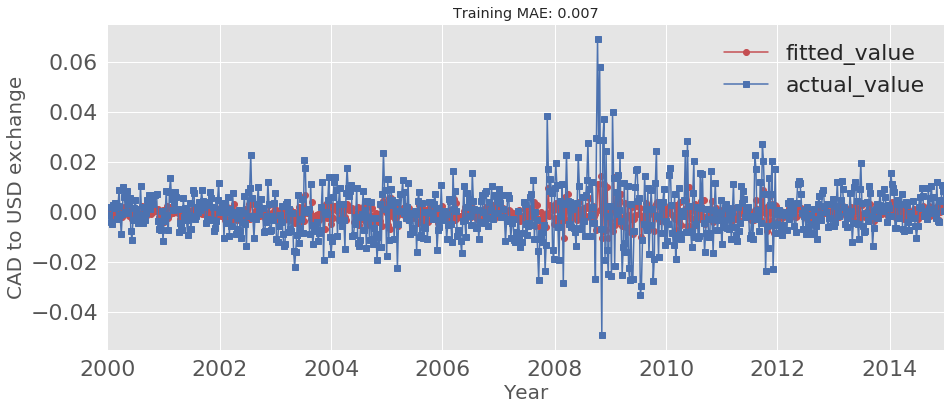

In [24]:
# Plot the result
plotTimeseries(series_train.fitted_value, color = 'r', marker = 'o')
plotTimeseries(series_train.actual_value, color = 'b', marker = 's')
plt.title('Training MAE: %.3f'%(MAE_train))
plt.legend(loc = 'best')
plt.show()

__Diagnostic plot__
Residuals for the training set. To check how well the model fits the data, we will conduct a residual diagnostic checks We make plots that to check if the residuals of the fitted values has a random pattern within the parallel horizontal line, which induicates that they are normally distributed.

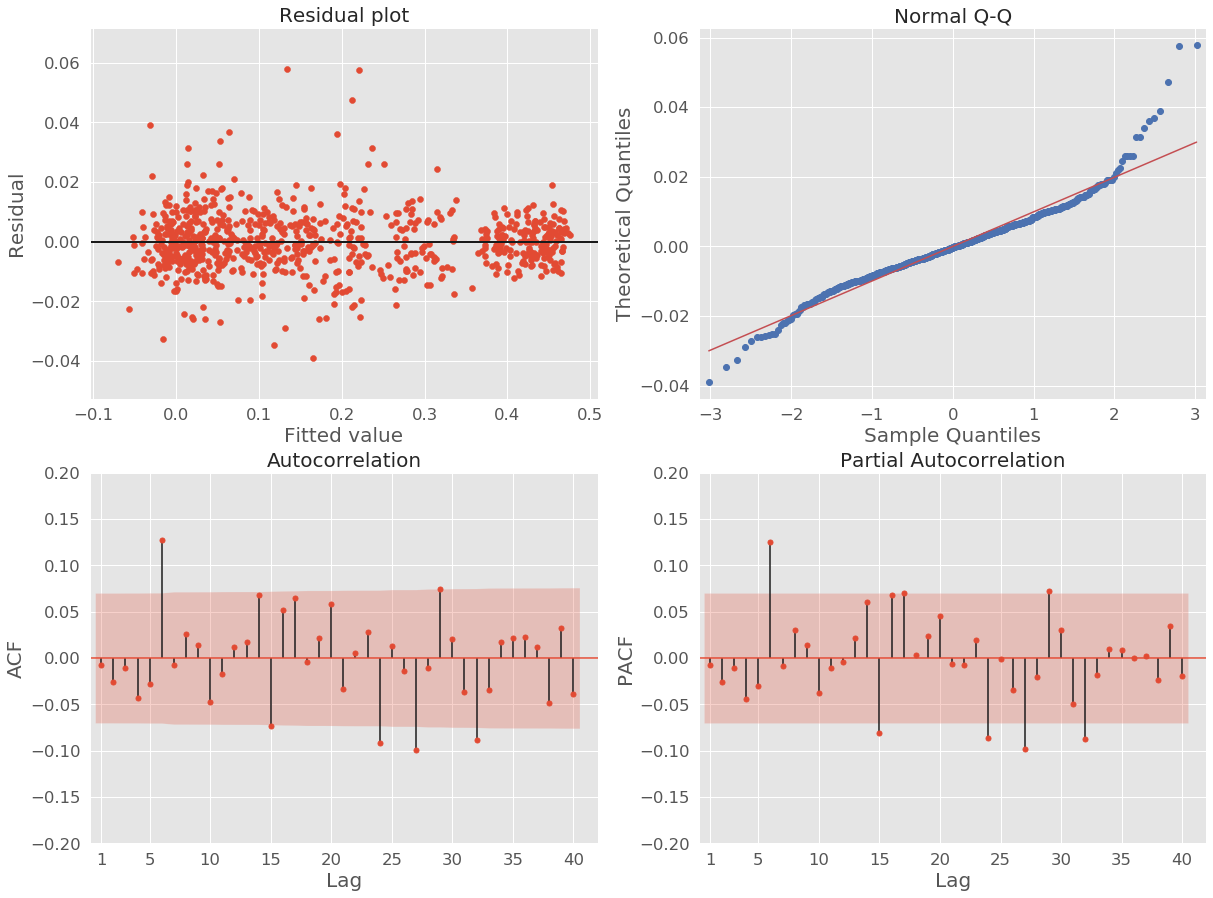

In [25]:
plotTrainDiagnostic(y_train, nlags=40)

We also see that the ACF and the PACF of the residuals are less than the 5% significant level. However, there are also few outliers from the top panel figures. In general, this result suggests that the model fits the data reasonably well and its adequate for forecasting future values.

__Model Out-of-Sample Forecasting__

In [26]:
test_results = testForecast(y_train, y_test)

In [27]:
test_results.head(2)

,Actual,Forecast
DATE,,
2015-01-04,1.167700,1.161552
2015-01-11,1.183104,1.169030


In [28]:
# Compute the r2 and MAE
r_sq = r_squared(test_results.Actual, test_results.Forecast)
MAE = mae(test_results.Actual, test_results.Forecast)
print('Test R squared: %.2f'%(r_sq))
print('Test MAE: %.2f'%(MAE))

Test R squared: 0.95
Test MAE: 0.01


__Plot of forecasted results__

Plot of the forecasted and actual result

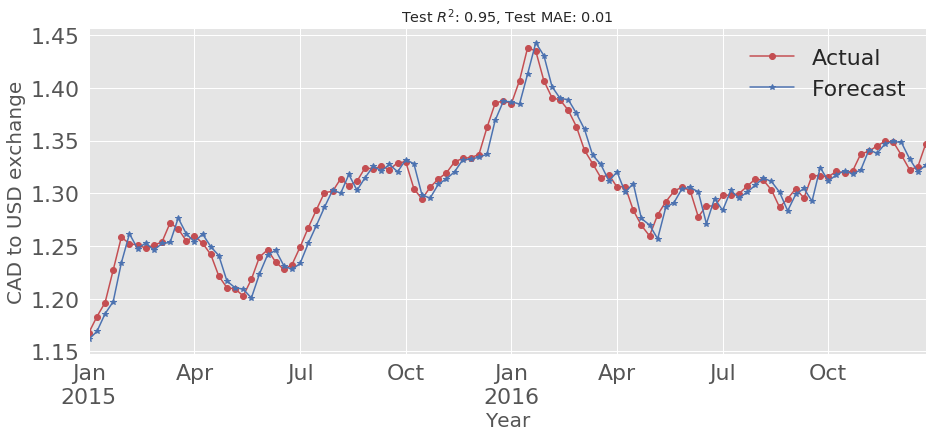

In [29]:
# Plot the result
plotTimeseries(test_results.Actual, color = 'r', marker = 'o')
plotTimeseries(test_results.Forecast,color = 'b', marker = '*')
plt.title('Test $R^2$: %.2f, Test MAE: %.2f'%(r_sq, MAE))
plt.legend(loc = 'best')

__Diagnostic Plot of Residuals__ for the Out-of-Sample Forecast

AttributeError: 'AxesSubplot' object has no property 'fontsize'

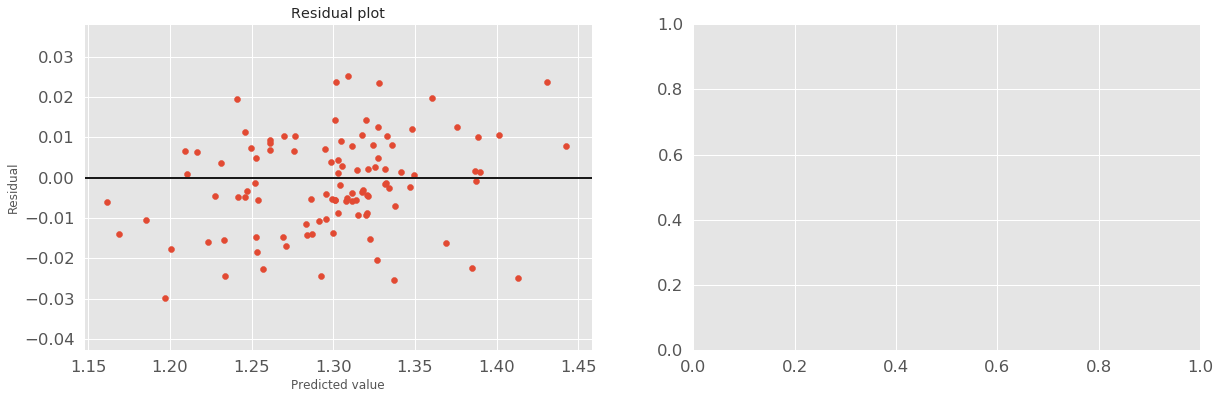

In [30]:
plotDiagnosticFocast(test_results, test_results.Actual, test_results.Forecast, nlags = 25)

#### Conclusion
We have doownloaded data of Canadian dollars to US dollars exchange rate, performed seasonality studies on it and performed ARIMA forcasting of the data.